In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.pulse import pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math

In [3]:
# Choose a real device to simulate
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [4]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_rochester') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q-ornl', group='ornl', project='phy141')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-ornl', group='ornl

In [5]:
for p in defaults.pulse_library:
    print(p.name)
    print()

M_m0

QId_d0

X90m_d0

X90p_d0

Xp_d0

Y90p_d0



In [6]:
Xp = lambda i: qiskit.pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [7]:
def measure_and_acquire(qubit):
    inst_sched_map = defaults.instruction_schedule_map
    measure = inst_sched_map.get('measure', qubits=qubit)
    return measure

meas_and_acq = measure_and_acquire(0)

In [8]:
import numpy as np

backend_defaults = backend.defaults()
dt = config.dt
print(f"Sampling time: {dt*1e9} ns") 

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Sampling time: 0.2222222222222222 ns
Qubit 0 has an estimated frequency of 4.974445794773773 GHz.
The sweep will go from 4.954445794773773 GHz to 4.994445794773773 GHz in steps of 1.0 MHz.


In [34]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.2602403423618312

In [11]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [224]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
drive_samples = 1616
drive_amp = 0.41585574148705895
rabi_schedules = []
durations = []
for i in range(num_rabi_points):
    duration = get_closest_multiple_of_16(drive_samples+(i*16))
    rabi_pulse = pulse_lib.GaussianSquare(duration=duration, 
                                    amp=drive_amp, 
                                    sigma=208,
                                    width=i*16,
                                    name=f"Rabi duration = {duration}")
    
    this_schedule = pulse.Schedule(name=f"Rabi duration = {duration}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += meas_and_acq << this_schedule.duration
    rabi_schedules.append(this_schedule)
    durations.append(duration)

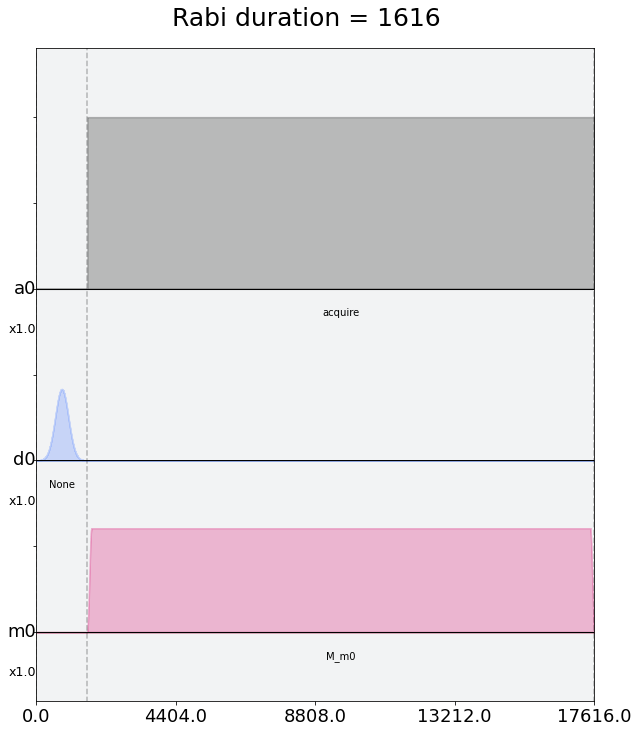

In [225]:
rabi_schedules[0].draw(scaling=1.0, label=True)

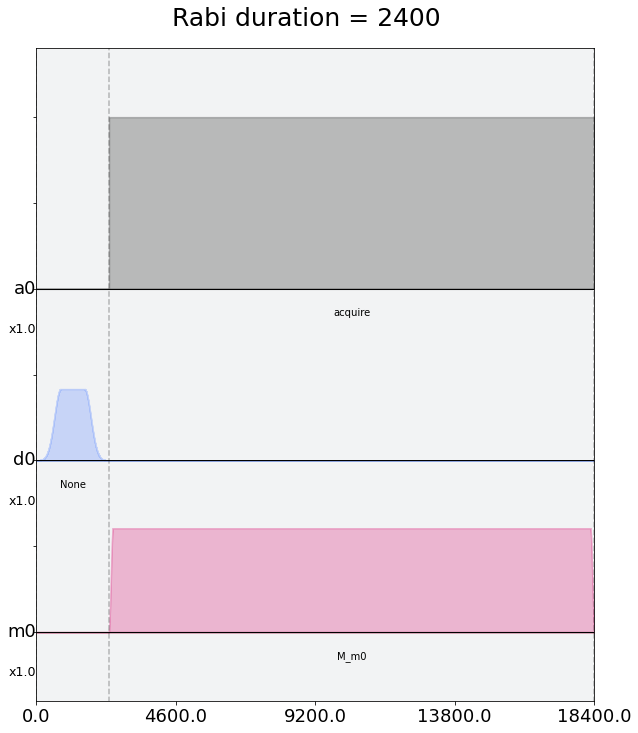

In [226]:
rabi_schedules[-1].draw(scaling=1.0, label=True)

In [227]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: defaults.qubit_freq_est[qubit]}]
                                                * num_rabi_points)
job = backend.run(rabi_experiment_program)
from qiskit.tools.monitor import job_monitor
print(job.job_id())
job_monitor(job)

5ee90bc5e5b3f10019f7074c
Job Status: job has successfully run


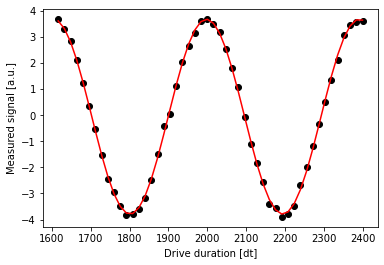

Period for amplitude = 0.41585574148705895, 393.5920338457813


In [230]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)
rabi_values = np.real(baseline_remove(rabi_values))

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
fit_params, conv = curve_fit(fit_func, durations, rabi_values, [8,0,600,0])
y_fit = [fit_func(x, fit_params[0], fit_params[1], fit_params[2], fit_params[3]) for x in durations]

plt.xlabel("Drive duration [dt]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(durations, rabi_values, color='black') # plot real part of Rabi values
plt.plot(durations, y_fit, color='red')
plt.show()
print(f'Period for amplitude = {drive_amp}, {fit_params[2]}')

In [193]:
fit_params

array([ 3.73447143e+00, -5.90978344e-02,  1.57436814e+03,  1.96256838e+00])

Period for amplitude = 0.2602403423618312, 1574.3681350839786
Period for amplitude = 0.41585574148705895, 393.5920332206272


In [ ]:
Pi Amplitude = 0.41585574148705895
Duration = 1616
Sigma = 208
